In [134]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import lines as mlines

In [2]:
import os
from astropy.table import Table
dirname = "/Users/aphearin/Dropbox/UniverseMachine/data/histories/prelim_sfh_reduction"
history_fname = "sfh_catalog_1.002310_smcut_9.50_value_added_histories.hdf5"
histories = Table.read(os.path.join(dirname, history_fname), path='data')

universe_age_array_fname = os.path.join(dirname, "times.npy")
universe_age_array = np.load(universe_age_array_fname)

In [6]:
from quenching_time import quenching_time
histories['quenching_time'] = quenching_time(histories['sfh'], histories['smh'])

In [7]:
cenmask = histories['upid'] == -1
cens = histories[cenmask]
sats = histories[~cenmask]

quenched_cenmask = (cens['sfr']/cens['sm'] < 1e-11)
quenched_cens = cens[quenched_cenmask]

quenched_satmask = (sats['sfr']/sats['sm'] < 1e-11)
quenched_sats = sats[quenched_satmask]

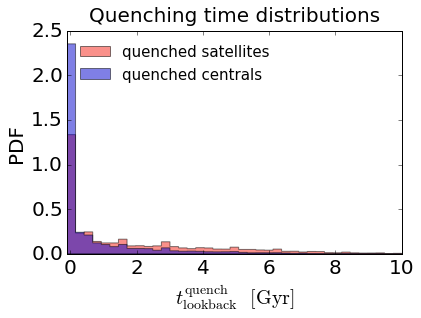

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$t_{\rm lookback}^{\rm quench}$  $[{\rm Gyr}]$', fontsize=20)
ylabel = ax.set_ylabel(r'PDF', fontsize=20)
title = ax.set_title('Quenching time distributions', fontsize=20, y=1.02) # y param fixes an overhanging title

lowsm, highsm = 10.4, 10.5
cens_sample_mask = (cens['sm'] > 10**lowsm) & (cens['sm'] < 10**highsm)
cens_sample = cens[cens_sample_mask]
sats_sample_mask = (sats['sm'] > 10**lowsm) & (sats['sm'] < 10**highsm)
sats_sample = sats[sats_sample_mask]

plt.hist(universe_age_array[-1] - sats_sample['quenching_time'], 
              normed=True, bins=np.linspace(-0.1, 10, 40), color='#f62217', 
              histtype='stepfilled', alpha=0.5, label='quenched satellites')

plt.hist(universe_age_array[-1] - cens_sample['quenching_time'], 
              normed=True, bins=np.linspace(-0.1, 10, 40), color='mediumblue', 
              histtype='stepfilled', alpha=0.5, label='quenched centrals')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(xmin = -0.1, xmax=10)
plt.legend(loc='upper left', fontsize=15, frameon=False)

# plt.savefig('FIGS/cens_sats_quenching_time.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

### now calculate the age-of-accretion from the scale-factor-of-accretion

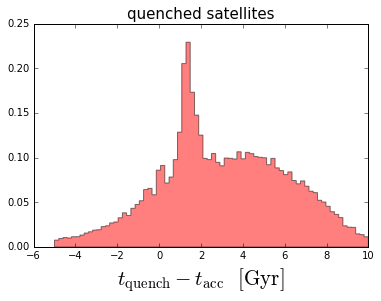

In [9]:
qsats_accretion_quenching_timescale = quenched_sats['quenching_time'] - quenched_sats['time_first_acc'] 

__ = plt.hist(qsats_accretion_quenching_timescale, 
              normed=True, bins=np.linspace(-5, 10, 75), color='red', 
              histtype='stepfilled', alpha=0.5, label='quenched satellites')

plt.xlabel(r'$t_{\rm quench} - t_{\rm acc}$  $[{\rm Gyr}]$', size=21)
plt.title('quenched satellites', size=15)
# plt.savefig('FIGS/qsats_tq_tacc_diff.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

In [11]:
qsats_mpeak_quenching_timescale = quenched_sats['quenching_time'] - qsats_tacc.value

__ = plt.hist(qsats_mpeak_quenching_timescale, 
              normed=True, bins=np.linspace(-5, 10, 75), color='red', 
              histtype='stepfilled', alpha=0.5, label='quenched satellites')
plt.xlabel(r'$t_{\rm quench} - t_{\rm Mpeak}$  $[{\rm Gyr}]$', size=21)
plt.title('quenched satellites', size=15)
plt.savefig('FIGS/qsats_tq_tmpeak_diff.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

NameError: name 'qsats_tacc' is not defined

itest = 161195
central galaxy with stellar mass of 10.64 and sSFR of -10.17
Why is this galaxy not shown as quenched?


/Users/aphearin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in log10


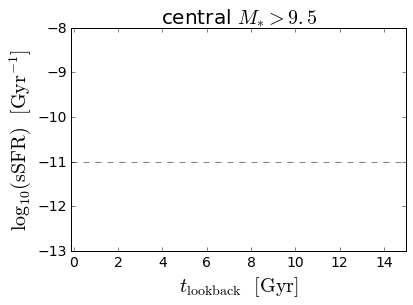

In [12]:
itest=np.random.randint(0, len(histories)-1)
itest = 161195


print("itest = {0}".format(itest))

h = histories[itest]
if h['upid'] == -1:
    gal_type = 'central'
else:
    gal_type = 'satellite'
    

ssfr_array = ssfr_matrix[itest, :]

print("{0} galaxy with stellar mass of {1:.2f} and sSFR of {2:.2f}".format(
    gal_type, np.log10(h['sm']), np.log10(h['sfr']/h['sm']) ))

if np.log10(h['sfr']/h['sm']) < -11:
    line_color = 'red'
else:
    line_color = 'blue'

toy_history = np.log10(ssfr_array)
plt.plot(universe_age_array[-1] - universe_age_array, toy_history, color=line_color)
plt.plot(np.linspace(-0.1, 15, 100), np.zeros(100)-11, '--', color='gray')

if gal_type == 'central':
    plt.title(r'central $M_{\ast} > 9.5$', size=20)
else:
    plt.title(r'satellite $M_{\ast} > 9.5$', size=20)
    
plt.xlabel(r'$t_{\rm lookback}$  $[{\rm Gyr}]$', size=20)
plt.xticks(size=14); plt.yticks(size=14)
plt.ylabel(r'${\rm log_{10}(sSFR})$  $[{\rm Gyr^{-1}}]$', size=20)

plt.xlim(xmin=-0.1, xmax=15)
plt.ylim(ymin=-13, ymax=-8)

print("Why is this galaxy not shown as quenched?")

## Now let's measure ${\rm d}M_{\ast} / {\rm d}t_{\rm since-infall}$

In [14]:
from history_functions import nearest_time_idx

In [15]:
sm_mask = (sats['sm'] > 10**10) & (sats['sm'] < 10**10.5)
sample = sats[sm_mask]
print("Number of satellites in the stellar mass range = {0}".format(len(sample)))

Number of satellites in the stellar mass range = 35585


In [21]:
idx_infall = nearest_time_idx(sample['quenching_time'])
idx_quenching = nearest_time_idx(sample['time_first_acc'])

In [172]:
idx_low, idx_high = 122, 150
idx_low, idx_high = 80, 134

print("t_high, t_low = {0:.2f}, {1:.2f}".format(
        universe_age_array[-1] - universe_age_array[idx_low], 
        universe_age_array[-1] - universe_age_array[idx_high]))

t_high, t_low = 9.48, 5.03


In [173]:
mask = (idx_infall >= idx_low) & (idx_infall <= idx_high)

sample_5tinf = sample[mask]
idx_quenching_sample_5tinf = idx_quenching[mask]
idx_infall_sample_5tinf = idx_infall[mask]
print("Number of satellites fixed-tinf sample = {0}".format(len(sample_5tinf)))

Number of satellites fixed-tinf sample = 3563


In [174]:
__ = np.searchsorted(universe_age_array, sample_5tinf['time_first_acc'])

In [211]:
delta_time_since_infall_bins = np.linspace(-4, 5, 30)
num_sample_5tinf = len(sample_5tinf)

mean_ssfr_post_infall = np.zeros(len(delta_time_since_infall_bins))
for ibin, dt in enumerate(delta_time_since_infall_bins):
    idx_dt = nearest_time_idx(sample_5tinf['time_first_acc'] + dt)
    sm_ibin = sample_5tinf['smh'][np.arange(num_sample_5tinf), idx_dt]
    sfr_ibin = sample_5tinf['sfh'][np.arange(num_sample_5tinf), idx_dt]
    nonzeromask = sm_ibin > 0.
    mean_ssfr_post_infall[ibin] = np.log10(np.mean(sfr_ibin[nonzeromask]/sm_ibin[nonzeromask]))    

In [212]:
mhost_bins = 10**np.array((12.5, 13, 13.5, 15))

sample_5tinf.sort('mvir_host_halo')

__ = np.searchsorted(sample_5tinf['mvir_host_halo'], mhost_bins)
idx_mass_range = np.append(np.insert(__, 0, 0), len(sample_5tinf))
print(idx_mass_range)

[   0  162  651 1553 3534 3563]


In [213]:
mean_ssfr_post_infall_mhost = np.zeros((len(mhost_bins), len(delta_time_since_infall_bins)))

for ibin, dt in enumerate(delta_time_since_infall_bins):
    idx_dt = nearest_time_idx(sample_5tinf['time_first_acc'] + dt)
    sm_ibin = sample_5tinf['smh'][np.arange(num_sample_5tinf), idx_dt]
    sfr_ibin = sample_5tinf['sfh'][np.arange(num_sample_5tinf), idx_dt]
    nonzeromask = sm_ibin > 0.
    idx_first = 0
    for j, mhost in enumerate(mhost_bins):
        idx_last = np.searchsorted(sample_5tinf['mvir_host_halo'][nonzeromask], mhost)
        ssfr_ij = sfr_ibin[nonzeromask][idx_first:idx_last]/sm_ibin[nonzeromask][idx_first:idx_last]
        mean_ssfr_post_infall_mhost[j, ibin] = np.log10(np.mean(ssfr_ij))
        idx_first = idx_last

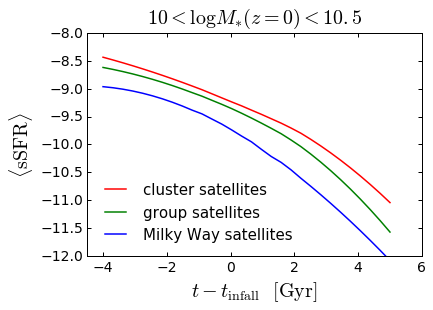

In [269]:
from scipy.signal import savgol_filter

fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$t - t_{\rm infall}$  $[{\rm Gyr}]$', fontsize=20)
ylabel = ax.set_ylabel(r'$\langle{\rm sSFR}\rangle$', fontsize=20)
title = ax.set_title(r'$10 < \log M_{\ast}(z=0) < 10.5$', fontsize=20, y=1.02) # y param fixes an overhanging title

lw = 1.5
ax.plot(delta_time_since_infall_bins, 
        savgol_filter(mean_ssfr_post_infall_mhost[-1, :], 19, 2),  
        color='red', label='cluster satellites', linewidth=lw)
ax.plot(delta_time_since_infall_bins, 
        savgol_filter(mean_ssfr_post_infall_mhost[2, :], 19, 2), 
        color='green', label='group satellites', linewidth=lw)
ax.plot(delta_time_since_infall_bins, 
        savgol_filter(mean_ssfr_post_infall_mhost[0, :], 19, 2), 
        color='blue', label='Milky Way satellites', linewidth=lw)

plt.xlim(xmin=-4.5, xmax=6)
plt.ylim(ymin = -12, ymax = -8.)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.tick_params(axis='x', length=4, width=1, which='major')
ax.tick_params(axis='x', length=2, width=1, which='minor')
ax.tick_params(axis='y', length=4, width=1, which='major')
ax.tick_params(axis='y', length=2, width=1, which='minor')

ax.legend(frameon=False, loc='lower left', fontsize=15)

fig.savefig('FIGS/post_infall_ssfr_sm10.pdf', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

## Ratio of sSFR

In [270]:
norm_mean_ssfr_post_infall_mhost = 10**mean_ssfr_post_infall_mhost[:, np.argmin(np.abs(delta_time_since_infall_bins))]
normed_mean_ssfr_post_infall_mhost = 10**mean_ssfr_post_infall_mhost/np.reshape(norm_mean_ssfr_post_infall_mhost, (4, 1))

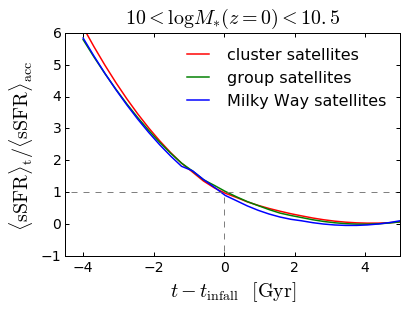

In [271]:

fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$t - t_{\rm infall}$  $[{\rm Gyr}]$', fontsize=20)
ylabel = ax.set_ylabel(r'$\langle{\rm sSFR}\rangle_{\rm t} / \langle{\rm sSFR}\rangle_{\rm acc}$', fontsize=20)
title = ax.set_title(r'$10 < \log M_{\ast}(z=0) < 10.5$', fontsize=20, y=1.02) # y param fixes an overhanging title

lw = 1.5
ax.plot(delta_time_since_infall_bins, 
        savgol_filter(normed_mean_ssfr_post_infall_mhost[-1, :], 19, 2),  
        color='red', label='cluster satellites', linewidth=lw)
ax.plot(delta_time_since_infall_bins, 
        savgol_filter(normed_mean_ssfr_post_infall_mhost[2, :], 19, 2), 
        color='green', label='group satellites', linewidth=lw)
ax.plot(delta_time_since_infall_bins, 
        savgol_filter(normed_mean_ssfr_post_infall_mhost[0, :], 19, 2), 
        color='blue', label='Milky Way satellites', linewidth=lw)

ax.plot(np.zeros(100), np.linspace(-5, 1, 100), '--', color='gray')
ax.plot(np.linspace(-10, 10, 100), np.ones(100), '--', color='gray')
plt.xlim(xmin=-4.5, xmax=5.)
plt.ylim(ymin = -1, ymax = 6.)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.tick_params(axis='x', length=4, width=1, which='major')
ax.tick_params(axis='x', length=2, width=1, which='minor')
ax.tick_params(axis='y', length=4, width=1, which='major')
ax.tick_params(axis='y', length=2, width=1, which='minor')

ax.legend(frameon=False, loc='upper right', fontsize=16)

fig.savefig('FIGS/post_infall_normalized_ssfr_sm10.pdf', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')